# Lab assignment №2: Gradient boosting and feature importance estimation

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

There are several great frameworks (listed below). However, we recommend to stick to `LightGBM` for this task.
* LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Parts 1 and 3 have the same weight equal to $1$. Part 2 has weight $0.5$.

### Part 1:
Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset:

* $\geq 90\%$ accuracy: 0.5 points for this part
* $\geq 92\%$ accuracy: 0.7 points for this part
* $\geq 94\%$ accuracy: 1 point for this part

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_roc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('ggplot')

In [3]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [4]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [5]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [6]:
try: 
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [7]:
pca = PCA(0.99)

In [8]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [9]:
X_train_pca.shape

(7352, 179)

In [10]:
X_test_pca.shape

(2947, 179)

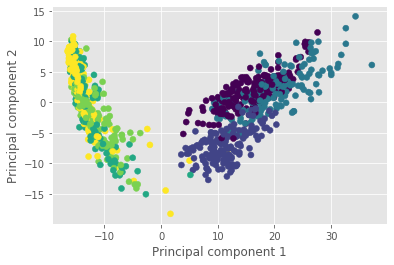

In [11]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

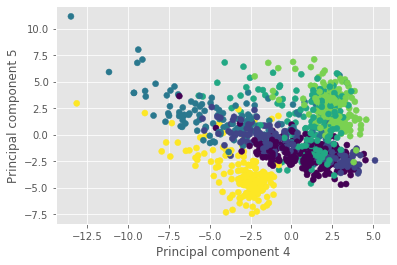

In [12]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')
plt.show()

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

Please try at least several models of different structure.

Provide the following to describe your path:

* Plot describing the model accuracy/precision/recall w.r.t. model complexity.
* ROC-AUC plot for the 3 best models you aquired (for multiclass case you might refer to the `scikit-plot` library.
* Small report describing your experiments.

[DART](https://arxiv.org/abs/1505.01866) might be useful as well in your experiments. It is available in [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html), but seems [missing in CatBoost](https://github.com/catboost/catboost/issues/1006).

__Without the report and plots maximum score for this part of the lab is 0.3 of its full weight.__

In [13]:
# make labels to be integer
y_train = y_train.astype(np.int)
y_test = y_test.astype(np.int)

In [14]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [15]:
def save_params(params_dict, estimator):
    for param in list(estimator.best_params_.keys()):
        params_dict[param] = estimator.best_params_[param]
    return params_dict

In [16]:
def print_results(estimator, estimator_type, X_test, y_test):
    print('F1 score for {} on test data: {}'.format(estimator_type, f1_score(estimator.predict(X_test), y_test, average='weighted')))
    print('Accuracy score for {} on test data: {}'.format(estimator_type, accuracy_score(estimator.predict(X_test), y_test)))
    print('Best score: {}'.format(estimator.best_score_))
    print('Best params: {}'.format(estimator.best_params_))

In [17]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, start_index, finish_index):
    scores_mean = cv_results['mean_test_score'][start_index:finish_index]
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score'][start_index:finish_index]
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    fig, ax = plt.subplots(figsize=(12, 8))

    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=16)
    ax.set_xlabel(name_param_1, fontsize=14)
    ax.set_ylabel('CV Average Score', fontsize=14)
    ax.legend(loc="best", fontsize=14)
    ax.grid('on')

Let's try different models.

__Logistic regression__

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
params_log_reg = {
    'multi_class': 'multinomial',
    'solver': 'lbfgs',
    'tol': 1e-4, 
    'max_iter': 500
}

log_reg = LogisticRegression(**params_log_reg)

param_distr_log_reg = {
    'C': np.logspace(-2, 2, 10)
}

In [20]:
%%time
clf_log_reg = RandomizedSearchCV(log_reg, param_distr_log_reg, scoring='accuracy', cv=3)
clf_log_reg.fit(X_train_unique, y_train)

CPU times: user 16min 29s, sys: 7min 15s, total: 23min 45s
Wall time: 3min 6s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=500,
                                                multi_class='multinomial',
                                                n_jobs=None, penalty='l2',
                                                random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.0000

In [21]:
print_results(clf_log_reg, 'logistic regression', X_test_unique, y_test)

F1 score for logistic regression on test data: 0.9580616857238213
Accuracy score for logistic regression on test data: 0.9579233118425518
Best score: 0.9387921653971708
Best params: {'C': 1.6681005372000592}


In [22]:
params_log_reg = save_params(params_log_reg, clf_log_reg)

In [23]:
print(params_log_reg)

{'multi_class': 'multinomial', 'solver': 'lbfgs', 'tol': 0.0001, 'max_iter': 500, 'C': 1.6681005372000592}


__SVM__

In [24]:
from sklearn.svm import SVC

In [25]:
svm = SVC()

param_distr_svm = {
    'C': np.logspace(-2, 2, 10),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': np.arange(0, 6, 1)
}

In [26]:
%%time
clf_svm = RandomizedSearchCV(svm, param_distr_svm, scoring='accuracy', cv=3)
clf_svm.fit(X_train_unique, y_train)

CPU times: user 9min 11s, sys: 306 ms, total: 9min 11s
Wall time: 9min 11s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=False,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                                        'degree': array([0, 1, 2, 3, 4, 5]),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                 

In [27]:
print_results(clf_svm, 'SVM', X_test_unique, y_test)

F1 score for SVM on test data: 0.952960593576955
Accuracy score for SVM on test data: 0.9528333898880217
Best score: 0.9371599564744287
Best params: {'kernel': 'poly', 'degree': 1, 'C': 4.6415888336127775}


In [28]:
params_svm = dict()
params_svm = save_params(params_svm, clf_svm)

__Decision Tree__

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
tree = DecisionTreeClassifier()

param_distr_tree = {
    'max_depth': np.arange(3, 11, 1),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': np.arange(2, 5, 1)
}

In [31]:
%%time
clf_tree = GridSearchCV(tree, param_distr_tree, scoring='accuracy', cv=3)
clf_tree.fit(X_train_unique, y_train)

CPU times: user 5min 13s, sys: 67.4 ms, total: 5min 13s
Wall time: 5min 13s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10])

In [32]:
print_results(clf_tree, 'Decision Tree', X_test_unique, y_test)

F1 score for Decision Tree on test data: 0.8354503576396622
Accuracy score for Decision Tree on test data: 0.8347472005429251
Best score: 0.8662948857453754
Best params: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}


In [33]:
params_tree = dict()
params_tree = save_params(params_tree, clf_tree)

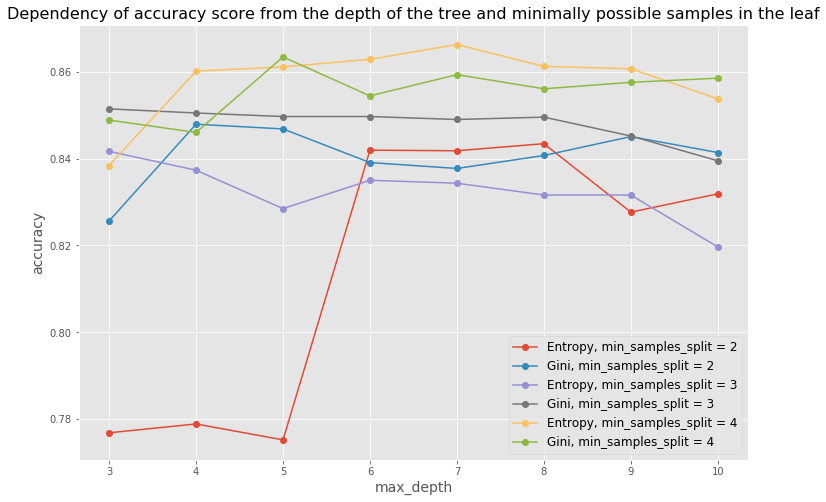

In [34]:
plt.figure(figsize=(12, 8))
plt.title("Dependency of accuracy score from the depth of the tree and minimally possible samples in the leaf",
          fontsize=16)
for i in range(param_distr_tree['min_samples_split'].shape[0]):
    plt.plot(np.arange(3, 11, 1), clf_tree.cv_results_['mean_test_score'][16 * i : (16 * i) + 8], 
             label='Entropy, min_samples_split = {}'.format(i + 2), marker='o')
    plt.plot(np.arange(3, 11, 1), clf_tree.cv_results_['mean_test_score'][(16 * i) + 8 : 16 * (i + 1)], 
             label='Gini, min_samples_split = {}'.format(i + 2), marker='o')
plt.legend(fontsize=12, loc='best')
plt.xlabel("max_depth", fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.show()

__Random Forest__

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
params_rf = {
    'criterion': 'entropy',
    'max_depth': params_tree['max_depth'],
    'min_samples_split': params_tree['min_samples_split']
}

random_forest = RandomForestClassifier(**params_rf)

param_distr_rf = {
    'n_estimators': np.arange(2, 100, 5)
}

In [37]:
%%time
clf_rf = GridSearchCV(random_forest, param_distr_rf, scoring='accuracy', cv=3)
clf_rf.fit(X_train_unique, y_train)

CPU times: user 5min 1s, sys: 59 ms, total: 5min 1s
Wall time: 5min 1s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='entropy', max_depth=7,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [38]:
print_results(clf_rf, 'Random Forest', X_test_unique, y_test)

F1 score for Random Forest on test data: 0.9109285116426266
Accuracy score for Random Forest on test data: 0.9104173736002714
Best score: 0.9160772578890098
Best params: {'n_estimators': 52}


In [39]:
params_rf = save_params(params_rf, clf_rf)

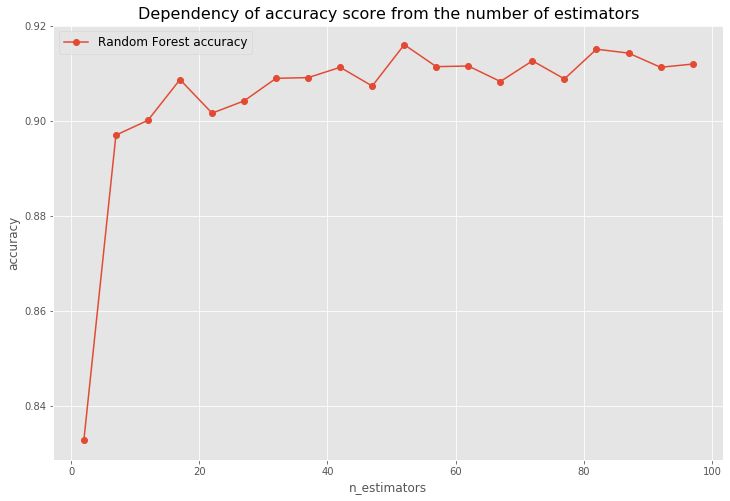

In [40]:
plt.figure(figsize=(12, 8))
plt.title("Dependency of accuracy score from the number of estimators",
          fontsize=16)
plt.plot(np.arange(2, 100, 5), clf_rf.cv_results_['mean_test_score'], label='Random Forest accuracy', marker='o')
plt.legend(fontsize=12, loc='best')
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.show()

__Gradient Boosting with LightGBM__

In [41]:
import lightgbm as lgb

In [42]:
params_gbm = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'max_depth': 2,
    'n_estimators': 100,
    'feature_fraction': 0.05,
    'objective': 'multiclass'
}

gbm = lgb.LGBMClassifier(**params_gbm)

In [43]:
n_estimators = np.arange(2, 100, 10)
max_depth = [2, 4, 6, 8, 10]

param_distr_gbm = {
    'boosting_type': ['gbdt', 'dart'],
    'n_estimators': n_estimators,
    'max_depth': max_depth
}

In [44]:
%%time
clf_gbm = GridSearchCV(gbm, param_distr_gbm, scoring='accuracy', cv=3)
clf_gbm.fit(X_train_unique, y_train)

CPU times: user 18min 58s, sys: 4.09 s, total: 19min 2s
Wall time: 2min 44s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.05,
                                      importance_type='split',
                                      learning_rate=0.05, max_depth=2,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31,
                                      objective='multiclass', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0),
             ii

In [45]:
print_results(clf_gbm, 'Gradient Boosting', X_test_unique, y_test)

F1 score for Gradient Boosting on test data: 0.9450172379656299
Accuracy score for Gradient Boosting on test data: 0.9446895147607737
Best score: 0.9261425462459195
Best params: {'boosting_type': 'gbdt', 'max_depth': 8, 'n_estimators': 92}


In [46]:
params_gbm = save_params(params_gbm, clf_gbm)

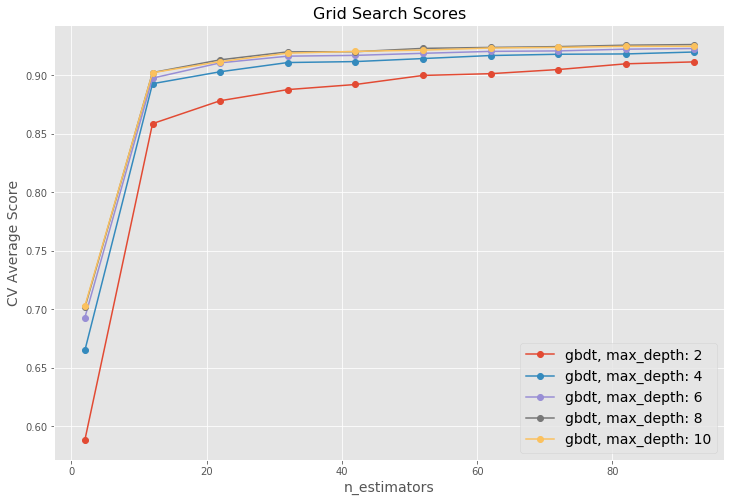

In [47]:
plot_grid_search(clf_gbm.cv_results_, n_estimators, max_depth, 'n_estimators', 'gbdt, max_depth', start_index=0, finish_index=50)

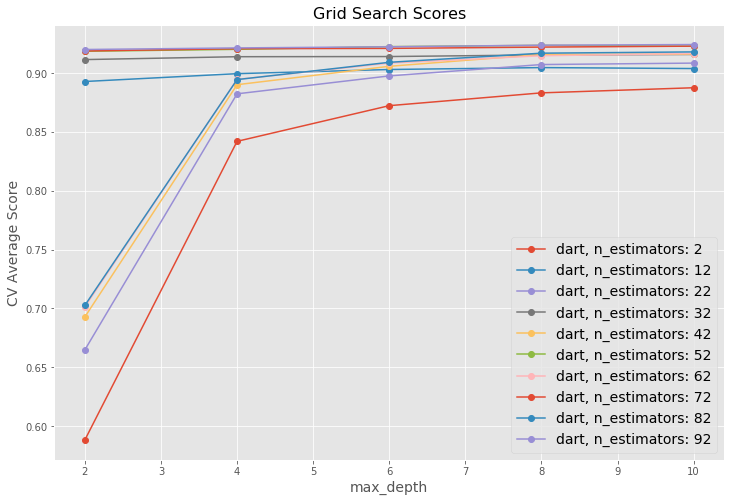

In [48]:
plot_grid_search(clf_gbm.cv_results_, max_depth, n_estimators, 'max_depth', 'dart, n_estimators', start_index=50, finish_index=100)

__Conclusions__

I have tested several models such as Logistic Regression, SVM, Decision Tree, Random Forest and Gradient Boosting. We can see that the best scores for test data were obtained by Gradient Boosting, SVM with linear kernel and Logistic Regression. For LigthGBM I had various number of estimators and the maximum depth of the tree, which allowed to get better perfomance. It is worth mentioning that the setting `feature_fraction` parameter for `LGBMClassifier` allowed to train models quicker and deal with overfitting.

Let's plot `ROC-AUC` for the models.

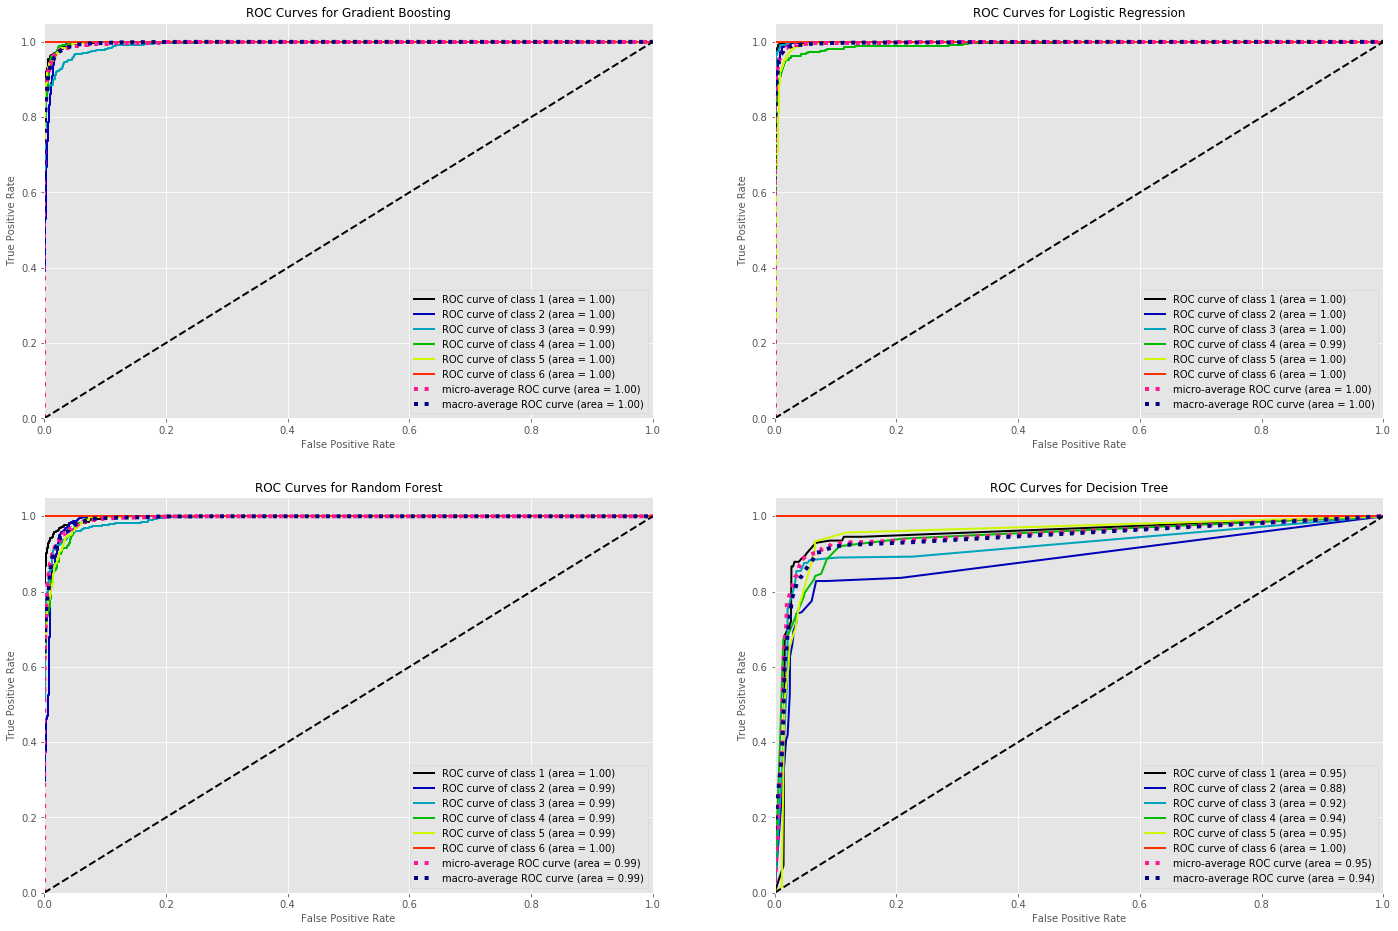

In [49]:
plt.figure(figsize=(24, 16))
plt.subplot(221)
plot_roc(y_test, clf_gbm.predict_proba(X_test_unique), figsize=(12, 8), title='ROC Curves for Gradient Boosting', ax=plt.gca())
plt.subplot(222)
plot_roc(y_test, clf_log_reg.predict_proba(X_test_unique), figsize=(12, 8), title='ROC Curves for Logistic Regression', ax=plt.gca())
plt.subplot(223)
plot_roc(y_test, clf_rf.predict_proba(X_test_unique), figsize=(12, 8), title='ROC Curves for Random Forest', ax=plt.gca())
plt.subplot(224)
plot_roc(y_test, clf_tree.predict_proba(X_test_unique), figsize=(12, 8), title='ROC Curves for Decision Tree', ax=plt.gca())
plt.show()

### Part 2. Blending the models

Take three (or more) best models and try to build the blending ensemble of them. Compare the quality of the final model using the same quality measures as above.

In [50]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [120]:
class Blending(BaseEstimator, ClassifierMixin):
    
    def __init__(self, models, meta_model):
        self.models = models
        self.meta_model = meta_model
        self.meta_matrix = None
        self.num_models = len(models)
        
    def fit(self, X_train, y_train, base_size=0.25):
        X_base, X_meta, y_base, y_meta = train_test_split(X_train, y_train, test_size=base_size)
        
        self.meta_matrix = np.zeros((X_meta.shape[0], self.num_models))
        for i, model in enumerate(self.models):
            model.fit(X_base, y_base)
            self.meta_matrix[:, i] = model.predict(X_meta)
            
        self.meta_model.fit(self.meta_matrix, y_meta)
        return self
    
    def predict(self, X_test):
        X_test_meta = np.zeros((X_test.shape[0], self.num_models))
        
        for i, model in enumerate(self.models):
            X_test_meta[:, i] = model.predict(X_test)
            
        result = self.meta_model.predict(X_test_meta)
        return result

In [121]:
models = [lgb.LGBMClassifier(**params_gbm), SVC(**params_svm), RandomForestClassifier(**params_rf)]
meta_model = LogisticRegression(**params_log_reg)

blending = Blending(models, meta_model)
blending.fit(X_train_unique, y_train)

Blending(meta_model=LogisticRegression(C=1.6681005372000592, class_weight=None,
                                       dual=False, fit_intercept=True,
                                       intercept_scaling=1, l1_ratio=None,
                                       max_iter=500, multi_class='multinomial',
                                       n_jobs=None, penalty='l2',
                                       random_state=None, solver='lbfgs',
                                       tol=0.0001, verbose=0,
                                       warm_start=False),
         models=[LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_...
                     tol=0.001, verbose=False),
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='entropy', max_depth=7,
                                        max_features='auto',
                                        max_leaf_nodes=No

In [122]:
print('F1 score for Blending on test data: {}'.format(f1_score(blending.predict(X_test_unique), y_test, average='weighted')))
print('Accuracy score for Blending on test data: {}'.format(accuracy_score(blending.predict(X_test_unique), y_test)))

F1 score for Blending on test data: 0.9487473277066154
Accuracy score for Blending on test data: 0.9484221241940957


Let's try to use several blendings to improve model.

In [54]:
from scipy.stats import mode

In [55]:
num_iters = 20
accuracy_scores = []

In [56]:
%%time

blending = Blending(models, meta_model)
blending.fit(X_train_unique, y_train)
results = blending.predict(X_test_unique)
accuracy_scores.append(accuracy_score(results, y_test))

for i in range(num_iters):
    new_blending = Blending(models, meta_model)
    new_blending.fit(X_train_unique, y_train)
    results = np.vstack((results, new_blending.predict(X_test_unique)))
    current_blending_result, _ = mode(results)
    accuracy_scores.append(accuracy_score(*current_blending_result, y_test))

CPU times: user 7min 49s, sys: 985 ms, total: 7min 50s
Wall time: 4min 51s


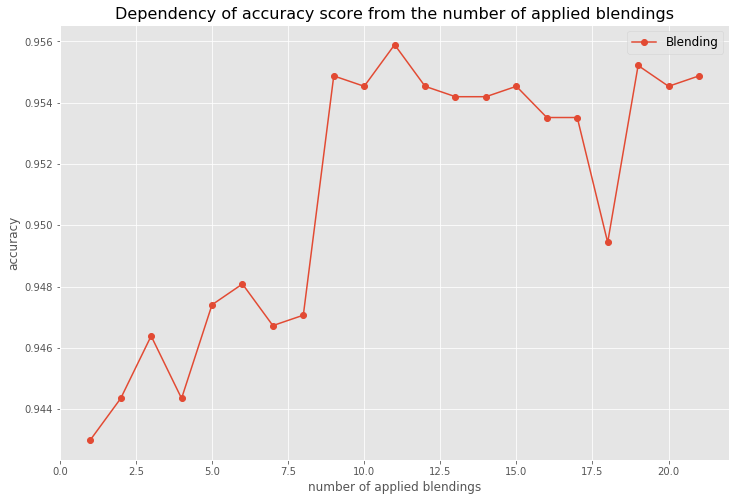

In [57]:
plt.figure(figsize=(12, 8))
plt.title("Dependency of accuracy score from the number of applied blendings", fontsize=16)
plt.plot(np.arange(1, 22, 1), accuracy_scores, label='Blending', marker='o')
plt.legend(fontsize=12, loc='best')
plt.xlabel('number of applied blendings', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.show()

__Conclusions__

We see that using the blending ensemble allows to improve model accuracy, especially when we use several blendings one by one. It happens because at each step we have have the different split of our data, which allows the model to be more precise. 

### Part 3. Explaining the model and estimating the feature importances.

Now your goal to take three best models and estimate feature importances using this models.

* First, use the methods that libraries provide by default (e.g. `lightgbm.plot_importance`).
* Next, use the [`shap`](https://github.com/slundberg/shap) library to explain the models behaviour and analyse the model performance. Compare the feature importances estimated by `shap` and by methods on the previous step.

Let's use default method `lightgbm.plot_importance` with LGBMClassifier.

In [58]:
gbm = lgb.LGBMClassifier(**params_gbm)
gbm.fit(X_train_unique, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.05, importance_type='split',
               learning_rate=0.05, max_depth=8, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=92,
               n_jobs=-1, num_leaves=31, objective='multiclass',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

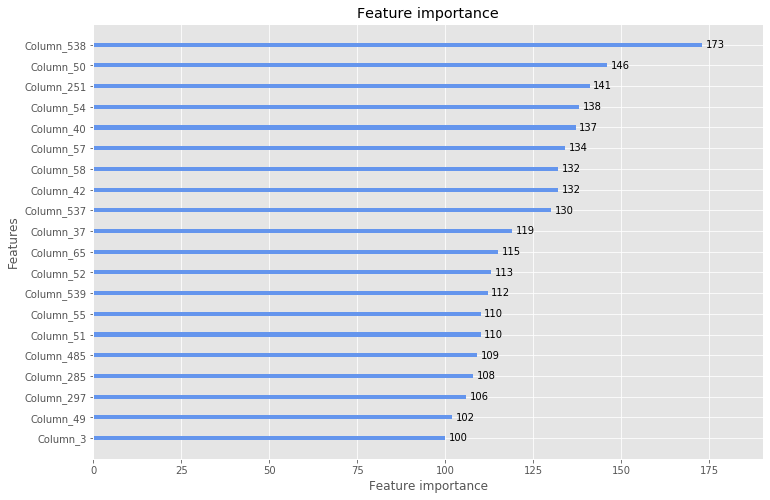

In [106]:
lgb.plot_importance(gbm, figsize=(12,8), max_num_features=20, color='cornflowerblue')
plt.show()

Now let's use `shap` and its method `summary_plot` to get more informative visualization.

In [115]:
import shap
shap.initjs()

In [99]:
shap_values = shap.TreeExplainer(gbm).shap_values(X_train_unique)

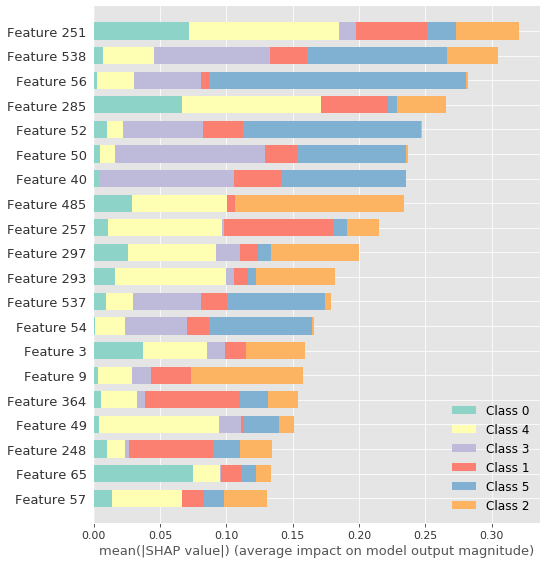

In [100]:
shap.summary_plot(shap_values, X_train_unique, plot_type='bar', color=plt.get_cmap('Set3'))

We can see that `shap` allows to get more information about classes and features which have the most influence on a specific class. For example, we see that:  
__Class 0__ is most influenced by __Feature 65, 251, 285__  
__Class 3__ is most influenced by __Feature 50, 40, 528__, etc.

Such visualizations allow to interpret models more precisely. For example, we see the __Class 5__ (__LAYING__ activity) is strongly influenced by the __Feature 56__. Due to `features.txt` file in `data/` folder we might assume that this is the feature `tGravityAcc-min()-Z` or `tGravityAcc-sma()` (it depends on whether the counter of features starts with 0 or 1, but I suppose that it starts with 0). `tGravityAcc-min()-Z` shows the lowest value in the array of accelerometer data along the axis Z. It seems reasonable that this feature has a great impact on __LAYING__ activity. Such conclusions can be made similarly with other classes and features.

Now let's define some other models, which we obtained in the __Part 1__ and try to apply methods from `shap` library to explain them.

In [112]:
X_test_df = pd.DataFrame(data=X_test_unique)

__Logistic Regression__

In [113]:
log_reg = LogisticRegression(**params_log_reg)
log_reg.fit(X_train_unique, y_train)

LogisticRegression(C=1.6681005372000592, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

Firstly, let's try `force_plot` method with some random entry of the test dataset.

In [114]:
K = 10
entry_index = 23

explainer_lr = shap.KernelExplainer(log_reg.predict_proba, shap.sample(X_train_unique, K))
shap_values = explainer_lr.shap_values(X_test_df.iloc[entry_index, :])
expected_value = explainer_lr.expected_value

for i in range(len(expected_value)):
    display(shap.force_plot(expected_value[i], shap_values[i], X_test_df.iloc[entry_index, :]))

We see 6 plots (the number of activity types) with model output values (the probabilities for the certain class). By these plots we are able to investigate what features have the biggest impact on the model output for a specific entry in our dataset. The highest probability is given to the Class 4 (counters starts with 0) and the most influential feature in this case is Feature 182.

__Random Forest__

In [62]:
rand_forest = RandomForestClassifier(**params_rf)
rand_forest.fit(X_train_unique, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=52,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Let's visualize the same as for the Logistic Regression and compare the results.

In [119]:
K = 10
entry_index = 23

explainer_lr = shap.TreeExplainer(rand_forest, X_train_unique)
shap_values = explainer_lr.shap_values(X_test_df.iloc[entry_index, :])
expected_value = explainer_lr.expected_value

for i in range(len(expected_value)):
    display(shap.force_plot(expected_value[i], shap_values[i], X_test_df.iloc[entry_index, :]))

We see that this model has different output values for this specific entry. The highest probability is also given to the Class 4, but the most influential feature in Feature 41 (this feature was also there in Logistic Regression in Class 4). 

__Conclusion__

Usage of the `shap` library allows to interpret models more precisely, which might be useful when it's important to describe the reasons of model output. Also it might be helpful when we want to find informative and non-informative features in our data.